In [1]:
import os
import shutil
from git import Repo
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import json
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient

# **📊 Choosing the Right Univariate Analysis Plot**  

## **🔍 Step 1: Key Statistical Measures (Default)**
Before visualizing, analyze the core statistics to understand the data distribution.  

| **Measure** | **Description** | **Why It Matters?** |
|------------|---------------|--------------------|
| **Count** | Number of non-null values | Checks data completeness |
| **Mean** | Average of values | Measures central tendency |
| **Median** | Middle value (50th percentile) | Less affected by outliers |
| **Mode** | Most frequent value | Useful for categorical or discrete data |
| **Min** | Smallest value | Defines range |
| **Max** | Largest value | Defines range |
| **Standard Deviation (std)** | Spread of data | Higher std = more variation |
| **Variance** | Squared standard deviation | Measures dispersion |
| **25th Percentile (Q1)** | Lower quartile | 25% of data falls below this |
| **75th Percentile (Q3)** | Upper quartile | 75% of data falls below this |
| **Interquartile Range (IQR)** | Q3 - Q1 | Helps detect outliers |
| **Skewness** | Asymmetry of data distribution | 0 = symmetric, >0 = right-skewed, <0 = left-skewed |
| **Kurtosis** | Measures tail weight | High = heavy tails, low = light tails |

---

## **📊 Step 2: Automated Graph Selection for Numerical Data**

### **1️⃣ Histogram (For Discrete Data)**
- **When to use?**  
  * To check **buckets (bins) and counts** in numeric data.  
  * Ideal for **discrete or grouped numerical data** (e.g., age groups, salaries).
  * Helps in detecting **skewness** and approximate **distribution**.  

- **Best Approach:**  
  - Use **Histogram + Key Statistics** if the data has **discrete values** (e.g., `10, 20, 30` bins).  
  - Example: Salary ranges, test scores, age groups.  

---

### **2️⃣ Kernel Density Estimation (KDE) Plot (For Continuous Data)**
- **When to use?**  
  * For **continuous numerical data** to visualize the **smooth density curve**.
  * Ideal for datasets with **many unique values** (e.g., height, weight, income).  
  * Useful when **understanding distribution trends** is more important than individual counts.  

- **Best Approach:**  
  - Use **KDE + Key Statistics** for **highly continuous** data.  
  - Example: Temperature, stock prices, blood pressure levels.  

---

### **📌 Step 3: BoxPlot?**
- ❌ **Not needed if outliers are already cleaned.**  
- ✅ **Use BoxPlot only when checking for remaining outliers.**  
- It helps **visualize skewness, quartiles, and anomalies.**

---

## **Summary Table for Numerical Data**  

| Data Type       | Recommended Plots |
|----------------|-----------------|
| Discrete Data (10, 20, 30, etc.) | **Histogram + Key Statistics** |
| Continuous Data (e.g., 0.1, 0.2, 0.3, etc.) | **KDE + Key Statistics** |
| Outlier Detection (if needed) | **BoxPlot** |

---

### **🚀 Final Approach:**
1️⃣ **Start with Key Statistical Measures.**  
2️⃣ **Use Histogram (Discrete) or KDE (Continuous).**  
3️⃣ **BoxPlot is optional (only if outliers exist).**  



## **Automated Graph Selection for Categorical Data**

| **Condition** | **Best Visualization** | **Reason** |
|--------------|-----------------|----------|
| **Unique categories > 10** | **Bar Chart** | Too many categories make Pie Charts cluttered. Bar charts handle large categories better. |
| **Unique categories ≤ 10** | **Pie Chart** | Pie charts are useful when comparing a few categories. |
| **Unique categories ≤ 5** | **Pie Chart (default)** | Clear and easy to interpret. |
| **For quick insights** | **Count Plot** | Seaborn’s `countplot()` provides a cleaner bar chart. |


In [2]:
def univariate(column):
    """
    Automated Univariate Analysis: Selects the best visualization 
    based on data type and characteristics.
    
    Parameters:
    - graphName: str -> The preferred visualization type (optional, default logic applies).
    - column: pandas Series -> The column to analyze.
    
    Returns:
    - Displays the appropriate visualization.
    - Prints Key Statistical Measures in a tabular format for numerical data.
    """
    
    columnType = column.dtype  # Get the column data type

    if pd.api.types.is_numeric_dtype(column):  # Check if numeric
        # Step 1: Key Statistical Measures (Default)
        key_stats = column.describe().to_frame().T  # Convert to DataFrame for tabular format
        key_stats.rename(index={0: "Statistics"}, inplace=True)
        print("📊 **Key Statistical Measures**:\n")
        print(key_stats.to_string(index=False), "\n")  # Print neatly formatted table

        # Step 2: Automated Graph Selection
        unique_values = column.nunique()

        plt.figure(figsize=(8, 4))  # Set figure size
        
        if unique_values < 20:  # Discrete Data
            print("🔍 Using Histogram for Discrete Data")
            sns.histplot(column, bins=10, kde=False, color="skyblue")
        
        else:  # Continuous Data
            print("🔍 Using KDE for Continuous Data")
            sns.kdeplot(column, fill=True, color="orange")

        plt.title(f"Univariate Analysis of {column.name}")
        plt.xlabel(column.name)
        plt.ylabel("Frequency")
        plt.show()

    elif pd.api.types.is_categorical_dtype(column) or column.nunique() < 10:  # Categorical Data
        category_counts = column.value_counts(normalize=True) * 100
        category_table = pd.DataFrame({"Category": category_counts.index, "Percentage": category_counts.values})
        print("📊 **Category Frequency Counts**:\n")
        print(category_table.to_string(index=False), "\n")  # Print neatly formatted category table

        plt.figure(figsize=(8, 4))
        print("🔍 Using Bar Chart for Category Distribution")
        sns.countplot(y=column, palette="pastel")

        plt.title(f"Univariate Analysis of {column.name}")
        plt.xlabel("Count")
        plt.ylabel(column.name)
        plt.show()

    else:
        print("⚠️ Unsupported Data Type")

    return True


In [3]:
def detect_outliers_iqr(dataFrame):
    try:
        numeric_cols = dataFrame.select_dtypes(include=['int64', 'float64']).columns.tolist()
        for column in numeric_cols:
            Q1 = dataFrame[column].quantile(0.25)
            Q3 = dataFrame[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = max(Q1 - 1.5 * IQR, dataFrame[column].min())
            upper_bound = min(Q3 + 1.5 * IQR, dataFrame[column].max())
            dataFrame[column] = np.where(dataFrame[column] < lower_bound, lower_bound, dataFrame[column])
            dataFrame[column] = np.where(dataFrame[column] > upper_bound, upper_bound, dataFrame[column])
            # print(f"Outliers handled in column: {column}")
        return dataFrame
    except Exception as e:
        print(f"Failed to detect outliers in {column}: {e}")
        raise

In [4]:
def FeatureEngineering_File_Extraction(repo_url, kaggle_repo_url, FeatureEngineering_path):
    if os.path.exists(kaggle_repo_url):
        print("Repository already exists locally.")
        repo = Repo(kaggle_repo_url)  
        repo.config_writer().set_value("user", "name", name).release()
        repo.config_writer().set_value("user", "email", email).release()
        origin = repo.remote(name='origin')  
        origin.pull() 
        print("Successfully pulled the latest changes.")
    else:
        repo = Repo.clone_from(repo_url, kaggle_repo_url)
        repo.config_writer().set_value("user", "name", name).release()
        repo.config_writer().set_value("user", "email", email).release()
        print("Successfully cloned the repository.")

   
    output_files = os.listdir(FeatureEngineering_path)
    FeatureEngineering_File = max(
        [file for file in output_files if file.startswith("FE_") and file.endswith('records.json')]
    )

   
    FeatureEngineering_File = pd.read_json(os.path.join(FeatureEngineering_path, FeatureEngineering_File))

    return FeatureEngineering_File

In [5]:
def PushToGithub(filename,destination_path):
    try:
        if os.path.exists(kaggle_repo_url):
            print("Already cloned and the repo file exists")
            repo = Repo(kaggle_repo_url)
            repo.config_writer().set_value("user", "name", name).release()
            repo.config_writer().set_value("user", "email", email).release()
            origin = repo.remote(name='origin')
            origin.pull()
            print("Successfully pulled the git repo before push")
        else:
            repo = Repo.clone_from(repo_url, kaggle_repo_url)
            repo.config_writer().set_value("user", "name", name).release()
            repo.config_writer().set_value("user", "email", email).release()
            print("Successfully cloned the git repo")
        
        if os.path.exists(destination_path):
            shutil.copyfile(f'/kaggle/working/{filename}', f'{destination_path}/{filename}')
        else:
            os.makedirs(destination_path)
            shutil.copyfile(f'/kaggle/working/{filename}', f'{destination_path}/{filename}')
        
        repo = Repo(kaggle_repo_url)
        repo.index.add([f"{destination_path}/{filename}"])
        timestamp = datetime.now(ist).strftime("%Y-%m-%d_%H:%M:%S")
        repo.index.commit(f"{timestamp} Added files from Kaggle notebook, {filename}")
        origin = repo.remote(name="origin")
        push_result = origin.push()
        
        if push_result:
            print("Output files successfully pushed to GitHub!")
        else:
            print("Output files pushed to GitHub failed:(")
        return True
    
    except Exception as e:
        print(f"An error occurred at git automation code: {e}")
        return False

In [6]:
def pre_eda_validation(dataFrame):

    report_df = pd.DataFrame({
        "missing_values": dataFrame.isnull().sum(),
        "duplicates": [dataFrame.duplicated().sum()] * len(dataFrame.columns),
        "data_types": dataFrame.dtypes.astype(str),
        "cardinality": dataFrame.nunique()
    }).reset_index().rename(columns={"index": "columns"})

    # Extract inconsistent records for group1
    inconsistent_group1 = dataFrame[dataFrame.duplicated(subset=["channelId"], keep=False)][
        ["channelId", "channelName", "channelCustomUrl", "channelGrowthScoreRank"]]

    # Extract inconsistent records for group2
    inconsistent_group2 = dataFrame[dataFrame.duplicated(subset=["videoId"], keep=False)][
        ["videoId", "videoTitle", "videoEngagementScoreRank"]]
    DataFrameHandelledOutliers = detect_outliers_iqr(dataFrame)
    report = {
        "Pre_EDA": report_df.to_dict(orient="records"),
        "inconsistent_records_channelLevel": inconsistent_group1.to_dict(orient="records"),
        "inconsistent_records_videolevel": inconsistent_group2.to_dict(orient="records"),
        "Dataframe": DataFrameHandelledOutliers.to_dict(orient="records")
    }
    record_count = len(DataFrameHandelledOutliers)
    timestamp = datetime.now(ist).strftime("%Y-%m-%d_%H_%M_%S")
    filename = f"PEDA_{timestamp}_{record_count}_records.json"

    if report["Pre_EDA"]:
        with open(filename, "w") as json_file:
            json.dump(report, json_file, indent=4)
        print(f"DataFrame validation report saved as {filename}")
    else:
        print("No data to save since empty DataFrame returned.")

    destination_path = '/kaggle/working/DevOps-YouTube-Trends/ExploratoryDataAnalysis/PEDA/Daily'
    PushToGithub(filename, destination_path)
        
    return True


In [7]:
def main(repo_url, kaggle_repo_url, FeatureEngineering_path, ExploratoryDataAnalysis_path):
    FeatureEngineering_File = FeatureEngineering_File_Extraction(repo_url, kaggle_repo_url, FeatureEngineering_path)
    pre_eda_validation(FeatureEngineering_File)
    univariate(FeatureEngineering_File["videoPublishMonth"])
    return True

Successfully cloned the repository.
DataFrame validation report saved as PEDA_2025-03-18_17_36_51_413_records.json
Already cloned and the repo file exists
Successfully pulled the git repo before push
Output files successfully pushed to GitHub!
📊 **Key Statistical Measures**:

 count     mean      std  min  25%  50%  75%  max
 413.0 6.326877 3.380007  1.0  3.0  6.0  9.0 12.0 

🔍 Using Histogram for Discrete Data


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


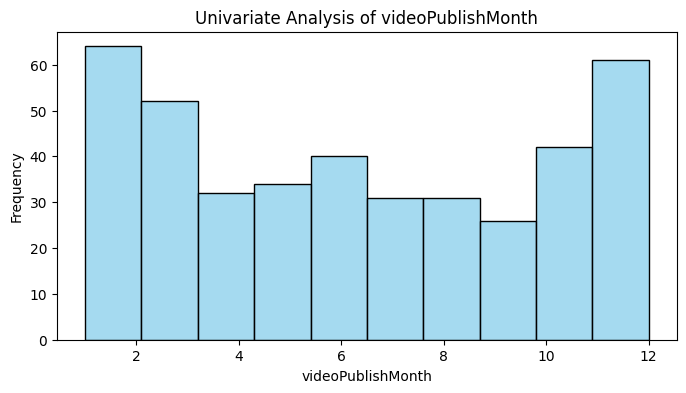

In [8]:
if __name__ == "__main__":    
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("EDARepoOwner")
    secret_value_1 = user_secrets.get_secret("EDARepoOwnerMail")
    secret_value_2 = user_secrets.get_secret("EDARepoURL")
    
    name = secret_value_0
    email = secret_value_1
    repo_url = secret_value_2
    
    kaggle_repo_url = '/kaggle/working/DevOps-YouTube-Trends'
    FeatureEngineering_path = '/kaggle/working/DevOps-YouTube-Trends/FeatureEngineering/Daily'
    ExploratoryDataAnalysis_path = '/kaggle/working/DevOps-YouTube-Trends/ExploratoryDataAnalysis'

    ist = timezone("Asia/Kolkata")
    
    main(repo_url, kaggle_repo_url, FeatureEngineering_path, ExploratoryDataAnalysis_path)